In [54]:
%load_ext autoreload
%autoreload 2
from objectives import *
from pebsi.processing.plotting_fxns import *
import pebsi.processing.gridsearch_processing as gsproc
from seasonal_error import *
import cmasher as cmr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pebsi.processing.gridsearch_plotting as gsplot
gsplot.find_precip_gradient('K17b','../MB_data/Kahiltna/Input_Kahiltna_Glaciological_Data.csv')

(<Figure size 600x300 with 1 Axes>, <Axes: ylabel='MB'>)

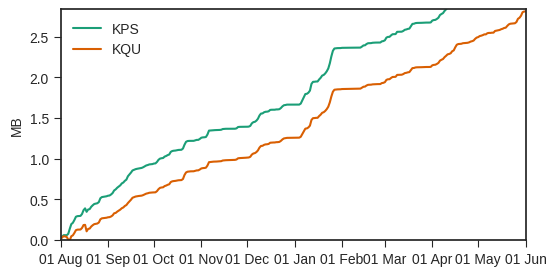

In [86]:
ds = xr.open_dataset('../Output/kahiltnaKQU_2025_09_26_9.nc')
dsp = xr.open_dataset('../Output/kahiltnaKPS_2025_09_26_2.nc')
# plt.plot(ds.time, ds.airtemp)
# plt.plot(ds_65.time, ds_65.airtemp)
# plot_seasonal_mass_balance(ds)
# plot_seasonal_mass_balance(dsp)
compare_runs([dsp, ds], [ds.time.values[0], ds.time.values[-1]], ['KPS','KQU'], 'MB')
# compare_runs([dsp, ds], [ds.time.values[0], ds.time.values[-1]], ['KPS','KQU'], 'accum')
# compare_runs([dsp, ds], [ds.time.values[0], ds.time.values[-1]], ['KPS','KQU'], 'cumrefreeze')

In [88]:
def calibrate_on_sites(sites, prints=False, plots=False, all_error = ['winter','summer','firndensity']):
    gsproc.sitedict['firn'] = sites
    result_dict = gsproc.get_result_dict(force_redo=True, parse_runs=['firn'])

    # ===== NORMALIZE =====
    lim_percentile = 75
    error_lims = {}
    for err in all_error:
        error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
    result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims, run_type='firn')

    # ===== FIND BEST PARAMETERS =====
    sites_calibrate = ['mean'] if len(sites) > 1 else sites
    for site in sites_calibrate: # gsproc.sitedict['firn']+['mean']:
        if prints:
            print(f'=========================={site}==========================')
        best_by = gsproc.get_best_normalized(all_error, result_dict, prints=prints, site=site)
        best = best_by[-1]
        
        if prints:
            winter_error = result_dict[best[0]][best[1]][site]['winter_ME']
            summer_error = result_dict[best[0]][best[1]][site]['summer_ME']
            density_error = result_dict[best[0]][best[1]][site]['firndensity_ME']
            print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}    Density bias {density_error:.1f}')
            winter_error = result_dict[best[0]][best[1]][site]['winter_MAE']
            summer_error = result_dict[best[0]][best[1]][site]['summer_MAE']
            density_error = result_dict[best[0]][best[1]][site]['firndensity_MAE']
            print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}    Density MAE {density_error:.1f}')

        for site in sites:
            if plots:
                ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
                fig, ax = plot_seasonal_mass_balance(ds)
                ax.set_title(ds.glacier.capitalize() + ' '+site+' calibrated to the mean of T and Z',fontsize=12)
                plt.show()
                dates, data = firn_cores(ds, out='data')
                plot_firn_cores(dates, data, site)

        return best

In [89]:
# site = 'T'
# folder_path = f'/trace/group/rounce/cvwilson/Output/09_24_{site}_1/'
# for filename in os.listdir(folder_path):
#     if filename.endswith('_'):
#         old_path = os.path.join(folder_path, filename)
#         new_filename = filename + '0.nc'  # removes trailing underscore
#         new_path = os.path.join(folder_path, new_filename)
#         os.rename(old_path, new_path)

==========================mean==========================
Weights:
    winter     summer firndensity     best
      1.00       0.00       0.00      ('3.25', '-8')
      0.00       1.00       0.00      ('2.5', '-3.5')
      0.00       0.00       1.00      ('3.5', '-8.5')
      0.33       0.33       0.33      ('3.5', '-3.5')
Winter bias: 0.02    Summer bias: -0.08    Density bias 57.9
Winter MAE: 0.26    Summer MAE: 0.54    Density MAE 105.0


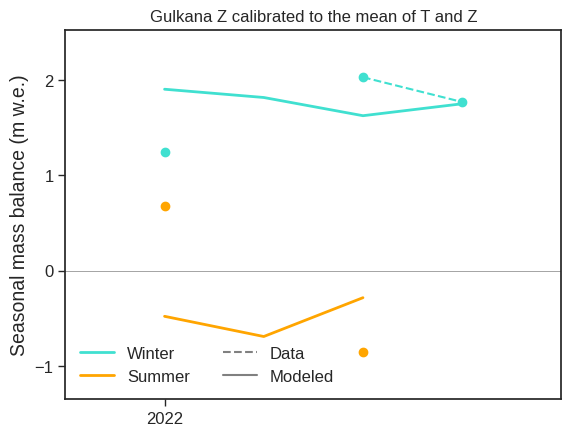

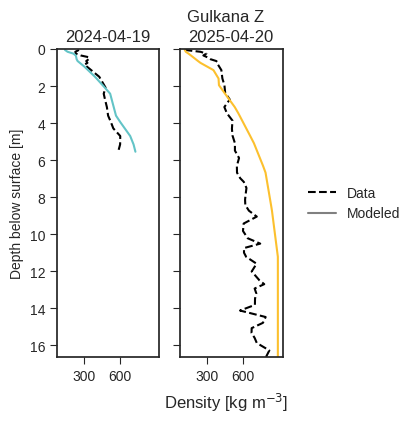

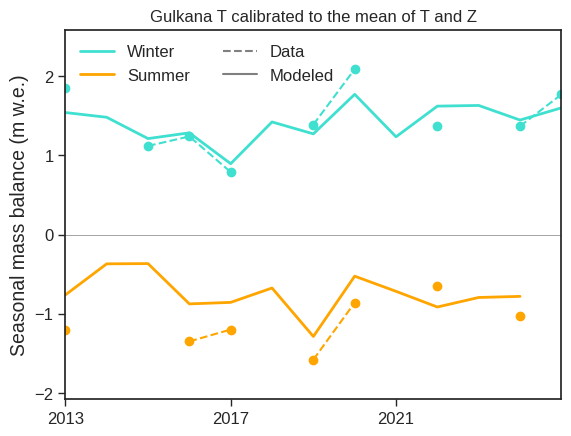

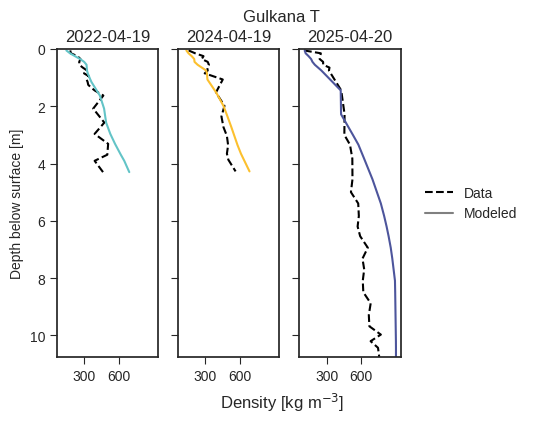

In [90]:
# ===== CALIBRATE ON GULKANA =====
sites = ['Z','T']
best_gulkana = calibrate_on_sites(sites, plots=True, prints=True)

==========================EC==========================
Weights:
    winter     summer firndensity     best
      1.00       0.00       0.00      ('2', '-8')
      0.00       1.00       0.00      ('2.5', '-8.5')
      0.00       0.00       1.00      ('3.5', '-8.5')
      0.33       0.33       0.33      ('2', '-8.5')
Winter bias: 0.25    Summer bias: -0.17    Density bias 105.9
Winter MAE: 0.38    Summer MAE: 0.38    Density MAE 130.1


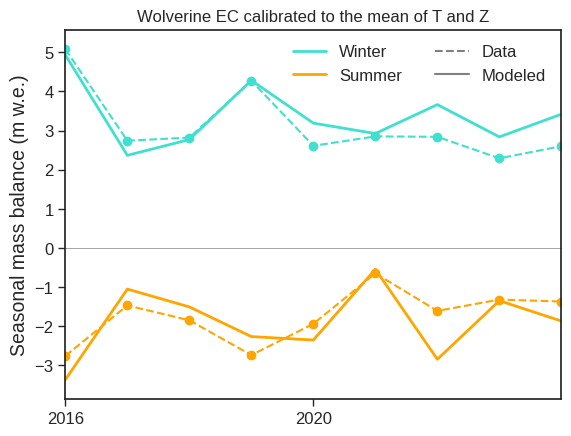

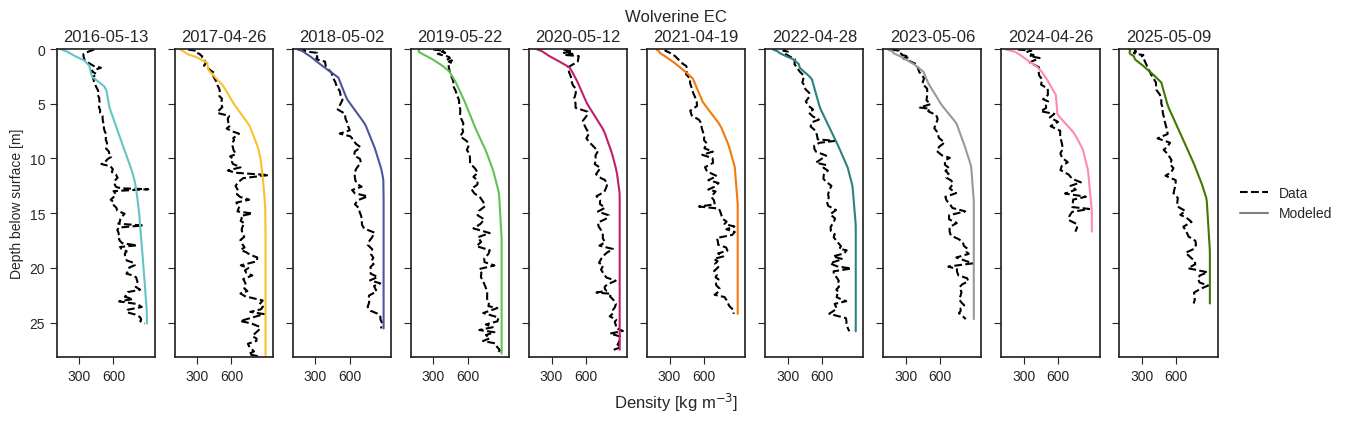

In [91]:
# ===== CALIBRATE ON WOLVERINE =====
best_wolverine = calibrate_on_sites(['EC'], prints=True, plots=True)

==========================KPS==========================
Weights:
    winter     summer firndensity     best
      1.00       0.00       0.00      ('2', '-7.5')
      0.00       1.00       0.00      ('1', '-7')
      0.00       0.00       1.00      ('3.5', '-5')
      0.33       0.33       0.33      ('2', '-7')
Winter bias: -0.19    Summer bias: 0.90    Density bias 4.6
Winter MAE: 0.58    Summer MAE: 1.27    Density MAE 97.7


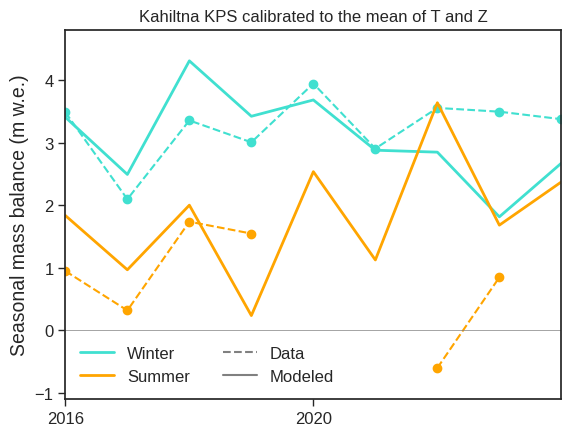

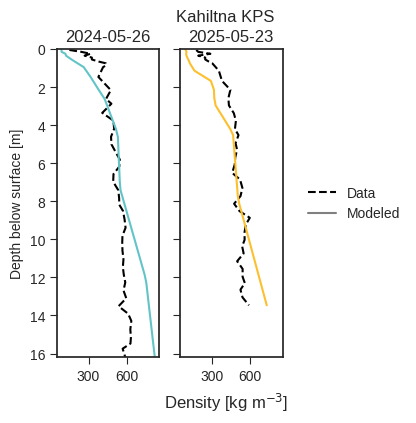

In [92]:
# ===== CALIBRATE ON KAHILTNA =====
best_kahiltna = calibrate_on_sites(['KPS'], prints=True, plots=True)

In [93]:
# RECALIBRATE ALL SITES WITHOUT FIRN CORES
best_dict = {}
for sites in [['Z','T'],['EC'],['KPS']]:
    glacier = 'gulkana' if 'Z' in sites else 'wolverine' if 'EC' in sites else 'kahiltna'
    best_dict[glacier] = calibrate_on_sites(sites, all_error=['winter','summer'])
best_gulkana_nocores = best_dict['gulkana']
best_wolverine_nocores = best_dict['wolverine']
best_kahiltna_nocores = best_dict['kahiltna']

In [94]:
print('With firn core accounting: ')
print(f'Gulkana parameters:     kp {best_gulkana[0]:<10}lapse_rate {best_gulkana[1]}')
print(f'Wolverine parameters:   kp {best_wolverine[0]:<10}lapse_rate {best_wolverine[1]}')
print(f'Kahiltna parameters:    kp {best_kahiltna[0]:<10}lapse_rate {best_kahiltna[1]}')
print()
print('Without firn core accounting:')
print(f'Gulkana parameters:     kp {best_gulkana_nocores[0]:<10}lapse_rate {best_gulkana_nocores[1]}')
print(f'Wolverine parameters:   kp {best_wolverine_nocores[0]:<10}lapse_rate {best_wolverine_nocores[1]}')
print(f'Kahiltna parameters:    kp {best_kahiltna_nocores[0]:<10}lapse_rate {best_kahiltna_nocores[1]}')

With firn core accounting: 
Gulkana parameters:     kp 3.5       lapse_rate -3.5
Wolverine parameters:   kp 2         lapse_rate -8.5
Kahiltna parameters:    kp 2         lapse_rate -7

Without firn core accounting:
Gulkana parameters:     kp 3.5       lapse_rate -3.5
Wolverine parameters:   kp 2         lapse_rate -8.5
Kahiltna parameters:    kp 1.75      lapse_rate -4


In [62]:
# var = 'surftemp'
# ds_base = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/Kahiltna_2025_09_22_noqmKPS_0.nc')
# og = ds_base[var].resample(time='YS-APR').sum()

# vary_vars = ['temp','wind','LWin','SWin','rh']
# vary_by = [0.5, 0.8, 1.2, 2]
# vary_by_temp = [5, 2, -2, -5]
# fig, axes = plt.subplots(1, len(vary_vars), figsize=(8, 4), sharex=False, sharey=False, gridspec_kw={'wspace':0.5})
# # cax = axes[-1]
# # axes = axes[:-1]
# cmap = cmr.iceburn
# norm = mpl.colors.Normalize(vmin=0, vmax=4)
# idx = [0, 1, 3, 4]
# for ax, vary in zip(axes, vary_vars):
#     time = og.time.values
#     if vary == 'temp':
#         vary_by_use = vary_by_temp
#         fp = '/trace/group/rounce/cvwilson/Output/test_forcings/09_23_KPS_0/'
#     else:
#         vary_by_use = vary_by
#         fp = '/trace/group/rounce/cvwilson/Output/test_forcings/09_23_KPS_2/'
#     print(vary_by_use)
#     # ax.plot(time, og.values, color=cmap(norm(2)), label='base')
#     for i, by in zip(idx, vary_by_use):
#         x = i if i < 2 else i-1
#         by_temp = vary_by_temp[x]
#         fn = fp + f'KPS_09_23_{vary}{by}_0.nc'
#         ds = xr.open_dataset(fn)
#         dsvar = ds[var].resample(time='YS-APR').mean()
#         # ax.plot(dsvar.time.values, dsvar.values - og.values, label=by, color=cmap(norm(i)))
#         mean = np.mean(dsvar[:-1])
#         ax.bar(x, mean, width=0.5, color=cmap(norm(i)))
#         # if vary == vary_vars[0]:
#         #     cax.plot(np.nan, np.nan, label=f'{by}', color=cmap(norm(i)))
#     # ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
#     # ax.set_xticks(pd.date_range(time[0], time[-1], freq='5YS'))
#     ax.axhline(0,color='k')
#     ax.set_title(vary) # 'Increasing wind / decreasing temperature') 
#     # ax.yaxis.set_label_position('right')
#     ax.tick_params(length=5)
#     ax.set_xticks([0,1,2,3])
#     ax.minorticks_on()
#     var_labels = ['x'+ str(v) for v in vary_by_use]
#     if vary == 'temp':
#         var_labels = ['+5','+2','-2','-5']
#     ax.set_xticklabels(var_labels, rotation=45)
#     # ax.set_ylim(0, 0.5)
# # cax.legend(loc='center', fontsize=12, title='Change factor', title_fontsize=13)
# # cax.axis('off')
# fig.supylabel('Mean annual melt')
# plt.show()

In [7]:
# var = 'melt'
# ds_base = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/Kahiltna_2025_09_22_noqmKPS_0.nc')
# og = ds_base[var].resample(time='YS-APR').sum()
# fp = '/trace/group/rounce/cvwilson/Output/test_forcings/09_23_KPS_3/'
# vary_vars = ['both']
# vary_by = [0.5, 0.8, 1, 1.25, 2]
# vary_by_temp = [5, 2, 0, -2, -5]
# fig, axes = plt.subplots(1, len(vary_vars)+1, sharex=True, sharey=True)
# cax = axes[-1]
# axes = axes[:-1]
# cmap = cmr.iceburn
# norm = mpl.colors.Normalize(vmin=0, vmax=4)
# idx = [0, 1,2,  3, 4]
# for ax, vary in zip(axes, vary_vars):
#     time = og.time.values
#     if vary == 'temp':
#         vary_by_use = vary_by_temp
#     else:
#         vary_by_use = vary_by
#     print(vary_by_use)
#     # ax.plot(time, og.values, color=cmap(norm(2)), label='base')
#     for i, by in zip(idx, vary_by_use):
#         by_temp = vary_by_temp[i]
#         fn = fp + f'KPS_09_23_{vary}{by}_0.nc'
#         ds = xr.open_dataset(fn)
#         dsvar = ds[var].resample(time='YS-APR').sum()
#         # ax.plot(dsvar.time.values, dsvar.values - og.values, label=by, color=cmap(norm(i)))
#         mean = np.mean(dsvar[:-1])
#         ax.bar(i, mean, width=0.5, color=cmap(norm(i)))
#         if vary == vary_vars[0]:
#             cax.plot(np.nan, np.nan, label=f'wind x {by}, temp + {by_temp}', color=cmap(norm(i)))
#     # ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
#     # ax.set_xticks(pd.date_range(time[0], time[-1], freq='5YS'))
#     ax.axhline(0,color='k')
#     ax.set_title('Increasing wind / decreasing temperature') # vary)
#     # ax.yaxis.set_label_position('right')
#     ax.tick_params(length=5)
#     ax.minorticks_on()
#     ax.set_xticklabels(['','','','',''])
# cax.legend(loc='center', fontsize=12, title='Change factor', title_fontsize=13)
# cax.axis('off')
# fig.supylabel('Mean annual melt')
# plt.show()

(<Figure size 500x170 with 2 Axes>, [<Axes: ylabel='Height above ice (m)'>])

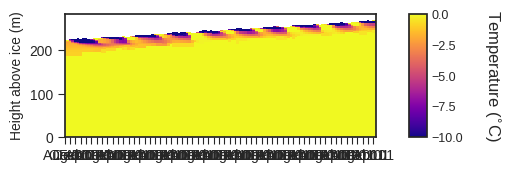

In [ ]:
# ds = gsproc.get_any(result_dict, best_kahiltna[0], best_kahiltna[1], site='KPS', run_type='firn')
# visualize_layers(ds, pd.date_range(ds.time.values[0], ds.time.values[-1], freq='MS'), ['layertemp'], plot_ice=True)

Use these parameters to perform a long simulation (1980-2025) and create the forcings file below

In [4]:
import xarray as xr
import pandas as pd

# open PEBSI simulation and associated climate (contains rainfall)
for site in ['KPS','EC','Z','T']: # 
    glacier = 'Gulkana' if site in ['Z','T'] else 'Wolverine' if site == 'EC' else 'Kahiltna'

    ds = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_09_25_long{site}_1.nc')
    # ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/Kahiltna_2025_09_24_longKPS_0.nc')
    # ds_tp = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_08_28_long{site}_climate.nc')['tp']
    timeres='1d'
    forcing_fn = f'/trace/group/rounce/cvwilson/Firn/Forcings/{glacier.lower()}{site}/{glacier.lower()}{site}_{timeres}_firncal_forcings.csv'

    # clip datasets to a common time
    # clip_time = pd.date_range('1980-04-15 00:00','2025-04-20 00:00',freq='h')
    # ds_tp = ds_tp.sel(time=clip_time)
    # ds = ds.sel(time=clip_time)

    # # changed output so updated runs have vaporsolid mass flux and old runs just have latent heat
    # if 'vaporsolid' in ds.variables:
    # get sublimation from any negative vaporsolid mass fluxes in m w.e.
    ds['vaporsolid'][ds['vaporsolid'] > 0] = 0
    ds['sublim'] = ds['vaporsolid']
    # else:
    #     # get sublimation from latent heat
    #     ds['sublim'] = ds.latent*3600/(2849000 * 1000) # latent (J s-1 m-2) * dt (s) / density_water (kg m-3) / lh_sub (J kg-1) --> m w.e.
    #     ds['sublim'][ds['sublim'] < 0] = 0
    #     ds['sublim'][ds.surftemp.values >= 0] = 0
    #     ds['sublim'] *= -1

    # get rain from total precipitation - accumulation (mask out any erraneous negatives)
    # ds['rain'] = ds_tp - ds['accum']
    # ds['rain'][ds['rain'] < 0] = 0

    # change units of surftemp
    ds['surftemp'] += 273.15

    # get surface density
    layer_thickness = ds.layerheight * 100
    cumulative_depth = layer_thickness.cumsum(dim='layer')
    mask = cumulative_depth <= 50
    weighted_density = ds.layerdensity * layer_thickness.where(mask)
    valid_thickness = layer_thickness.where(mask).sum(dim='layer')
    surfdens = weighted_density.sum(dim='layer') / valid_thickness
    ds['surfdens'] = surfdens

    # resample to the specified resolution with sum (mass balance terms) and mean (surface temp)
    ds_mb = ds[['melt','accum','rainfall','sublim']].resample(time=timeres).sum()
    ds_mb *= 1000   # convert m w.e. to kg m-2
    ds_other = ds[['surftemp','surfdens']].resample(time=timeres).mean()

    # merge datasets and rename
    data_in = xr.merge([ds_mb, ds_other])
    data_in = data_in.rename_vars({'melt':'SMELT', 'rainfall':'RAIN', 'surftemp':'TS', 'accum':'BDOT','sublim':'SUBLIM','surfdens':'RHOS'})

    # store data as a .csv
    df = data_in[['BDOT','RAIN','TS','SMELT','SUBLIM']].to_dataframe()
    print(forcing_fn)
    df.to_csv(forcing_fn)

/trace/group/rounce/cvwilson/Firn/Forcings/kahiltnaKPS/kahiltnaKPS_1d_firncal_forcings.csv
/trace/group/rounce/cvwilson/Firn/Forcings/wolverineEC/wolverineEC_1d_firncal_forcings.csv
/trace/group/rounce/cvwilson/Firn/Forcings/gulkanaZ/gulkanaZ_1d_firncal_forcings.csv
/trace/group/rounce/cvwilson/Firn/Forcings/gulkanaT/gulkanaT_1d_firncal_forcings.csv


In [ ]:
# END